# Data block API for audio

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_07a import *
from exp.nb_07a import *
from exp.nb_07a import *
from exp.nb_08 import *
from exp.nb_08za import *
from exp.nb_08zb import *

In [3]:
#Export 
import re

In [4]:
from IPython.display import Audio # No cheat here ;-)

## Data Block classes

### AudioList
This class is responsible to contain a list of AudioData.

#### Internal mechanics:
The data are actually stored inside the property "items" of ItemList. When we call:
```python
    il = AudioList.from_folder(...)
    audiodata = il[0]
    assert AudioData == type(audioData)
```
What happens behind the scene is this:  
```python
    filePath = il.items[0] # retrive original data
    assert PosixPath == type(filePath)
    audioData = il.get(filePath) # try to "construct" the informaiton from path
    assert AudioData == type(audioData)
```




In [5]:
#Export 
def default_audio_loader(f):
    '''Default audio loader'''
    return AudioData.load(f)

In [6]:
#Export
class AudioList(ItemList):
    
    def __init__(self, items, loader=default_audio_loader, *args, **kwargs):
        super().__init__(items, *args, **kwargs)
        self.loader=default_audio_loader
            
    def get(self, item): 
        #Item is already AudioData
        if isinstance(item, AudioData): return item
        #Item is a path - ie: from_folder
        if isinstance(item, (Path, str)): return AudioData.load(str(item)) 
        #Item is a tuple
        if isinstance(item, (tuple, np.ndarray)): return AudioData(item[0],item[1])
        #Otherwise
        raise Exception(f"Format not supported: {type(item)}") 

    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
        
    @classmethod
    def from_folder(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = audio_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)

## Testing

### Sample data for test

In [7]:
path = getSampleAudioDataFiles()
good_sample = path.ls()[256] # arbitrary choice of file
example = AudioData.load(good_sample)

Working directory: /home/ste/.fastai/data/ST-AEDS-20180100_1-OS


In [8]:
def test_AudioList_from_folder():
    from pathlib import PosixPath # Used for test
    
    p = path

    #Create AudioList
    il = AudioList.from_folder(p)
    
    #Test an item
    i=4
    
    #Under the hood..
    filePath = il.items[i] # retrive original data
    assert PosixPath == type(filePath)
    audioData = il.get(filePath) # try to "construct" the informaiton from priginal data
    assert AudioData == type(audioData)
    
    #The easy way
    a = il[i]
    assert AudioData == type(a) 
    print(a.sig.shape, a.sr)
    display(a)
    
    print('DONE') # Ensure the test has been completed ;-)

test_AudioList_from_folder()

torch.Size([62720]) 16000


DONE


## Split Train and Validation

### Split function

In [9]:
#Export
def split_by_random_percentage(items, validPct=.2):
    from random import shuffle
    tmp = list(items) # clone
    shuffle(tmp) # shuffle
    split = int(len(tmp)*validPct)
    t = tmp[:-split]
    v = tmp[-split:]
    return t,v

In [10]:
def test_split_by_random_percentage():
    il = AudioList.from_folder(path)
    pct = .3
    train,valid = split_by_random_percentage(il.items,pct)
    assert list==type(train) #no magick
    assert list==type(valid) #no magick
    act_pct = float(len(valid))/float(len(train) + len(valid))
    print(f'Actual validation percentage: {act_pct}')
    assert act_pct <= pct
    print('DONE') # Ensure the test has been completed ;-)
    
test_split_by_random_percentage()

Actual validation percentage: 0.29984383133784487
DONE


### AudioSplitData

In [11]:
#Export
class AudioSplitData(SplitData): #WARNING: this method is generic and should be ported to SplitData
    @classmethod
    def split_by_random_percentage(cls, il, validPct=.2):
        lists = map(il.new, split_by_random_percentage(il.items, validPct=validPct))
        return cls(*lists)

In [12]:
def test_AudioSplitData_split_by_random_percentage():
    il = AudioList.from_folder(path)
    pct = .3
    sd = AudioSplitData.split_by_random_percentage(il,pct)
    assert AudioList==type(sd.train) #no magick
    assert AudioList==type(sd.valid) #no magick
    act_pct = float(len(sd.valid))/float(len(sd.train) + len(sd.valid))
    print(f'Actual validation percentage: {act_pct}')
    assert act_pct <= pct
    print('DONE') # Ensure the test has been completed ;-)

test_AudioSplitData_split_by_random_percentage()

Actual validation percentage: 0.29984383133784487
DONE


## Labeling

In [13]:
#Export
def re_labeler(fileName,pattern): 
    #thnx fat.ai ;-)
    fn = str(fileName) # Ensure is a string
    pat = re.compile(pattern)
    found = pat.search(fn)
    if found: return found.group(1)
    return None

In [14]:
def test_re_labeler():
    label_pattern = r'_([mf]\d+)_'    
    ans = re_labeler('/home/ste/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00174.wav',label_pattern)
    print(f'Found: {ans}')
    assert 'm0005' == ans
    assert None == re_labeler('wrong/path/to/file',label_pattern)
    print('DONE') # Ensure the test has been completed ;-)
    
test_re_labeler()

Found: m0005
DONE


## Transforms

In [15]:
sample = AudioData.load(path.ls()[0])
sample

↓ Original ↓


↓ Transformed ↓


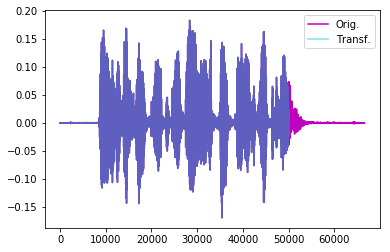

In [43]:
pad_sound = partial(tfm_pad_to_max, mx=50000)
try_audio_tfm(sample, pad_sound)

↓ Original ↓


↓ Transformed ↓


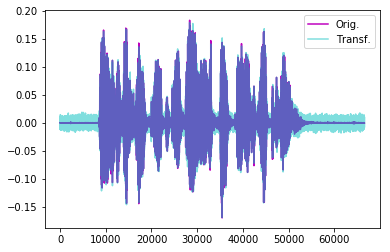

In [44]:
add_whitenoise = partial(tfm_add_white_noise, noise_scl=.005)
try_audio_tfm(sample, add_whitenoise)

'↓ Original ↓'

'Tensor shape=(1, 64, 444)'

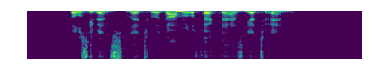

In [45]:
to_spectrogram = partial(tfm_spectro, n_mels=64, ws=300, n_fft=1024, to_db_scale=True)
#showTensorAsImage(to_spectrogram(sample))
try_spectro_tfm(sample, to_spectrogram)

## Label list with transforms (almost done)

In [18]:
#Export
def add_tfms_to_label_list(ll, tfmsl):
    ll.train.x.tfms = tfmsl[0]
    ll.valid.x.tfms = tfmsl[1]
    return ll

In [46]:
showLog = False
#train_tfms = [partial(tfm_log, msg='TRAIN TFMS: ', show=showLog), add_whitenoise, to_spectrogram]
#valid_tfms = [partial(tfm_log, msg='VALID TFMS: ', show=showLog), to_spectrogram]

train_tfms = [add_whitenoise, pad_sound, to_spectrogram]
valid_tfms = [pad_sound, to_spectrogram]

tfmsl = [train_tfms,valid_tfms] #list of transforms

In [47]:
label_pattern = r'_([mf]\d+)_'

In [48]:
il = AudioList.from_folder(path)
sd = AudioSplitData.split_by_random_percentage(il,.2)
ll = label_by_func(sd, partial(re_labeler,pattern=label_pattern), proc_y=CategoryProcessor())
ll = add_tfms_to_label_list(ll,tfmsl)

### Take a look at some samples...

In [49]:
display('Original data: ', il[0])

'Original data: '

'x'

'Tensor shape=(1, 64, 334)'

'y'

0

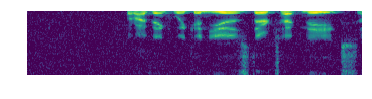

In [50]:
xy_sample = ll.train[0]
display('x')
showTensorAsImage(xy_sample[0])
display('y')
display(xy_sample[1])

## DataLoaders

In [51]:
bs = 32
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4)

In [52]:
x,y = next(iter(train_dl))

In [53]:
x.shape

torch.Size([32, 1, 64, 334])

In [54]:
y

tensor([1, 7, 5, 8, 2, 7, 3, 3, 2, 8, 7, 1, 8, 7, 3, 5, 8, 8, 0, 2, 6, 8, 5, 1,
        2, 5, 7, 1, 0, 3, 2, 6])

In [63]:
#Export 
def get_all_classes_for_label_list(ll):
    return list(set(ll.train.y.items + ll.valid.y.items))

In [64]:
get_all_classes_for_label_list(ll)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## DataBunch

In [65]:
il = AudioList.from_folder(path)
sd = AudioSplitData.split_by_random_percentage(il,.2)
ll = label_by_func(sd, partial(re_labeler,pattern=label_pattern), proc_y=CategoryProcessor())
ll = add_tfms_to_label_list(ll,tfmsl)

spectro_channels = 1
num_classes = len(get_all_classes_for_label_list(ll))
data = ll.to_databunch(bs, c_in=spectro_channels, c_out=num_classes, num_workers=4)

In [36]:
ll.train[0]

TypeError: list indices must be integers or slices, not PosixPath

## Sample AudioDataBunch Usage

<span style="color:red">CURRENTLY BROKEN</span>

In [ ]:

# def process_phn_file(p_file, sig, sr, delimiter=' '):
#     df = pd.read_csv(p_file, delimiter=delimiter, header=None)
#     df.columns = ['Start', 'End', 'Phn']
#     df['SampleAndSr'] = df.apply(lambda x : (sig[-1][x['Start']: x['End']], sr), axis=1)
#     return df

# def create_phn_df(path, count=100):
#     phns = []
#     final = pd.DataFrame()

#     for phn_file in glob.glob(str(path/'**/*.PHN'), recursive=True)[:count]:
#         sig,sr = torchaudio.load(str(phn_file.replace('PHN', 'WAV')))
#         df = process_phn_file(phn_file, sig, sr, delimiter=' ')
#         df['Source'] = phn_file
#         final = final.append(df, ignore_index=True)
#     return df

# df = create_phn_df(path/'TRAIN')
# df.head()

In [ ]:
# step0 = AudioList.from_df(df, path, cols=['SampleAndSr']); print(type(step0))

In [ ]:
# step0

In [ ]:
# step1 = step0.split_by_rand_pct(0.1, seed=1);
# print(f'Result type: {type(step1)}, Type of Items: {type(step1.lists[0])}')

In [ ]:
# step2 = step1.label_from_df('Phn');
# print(f'Result type: {type(step2)}')

In [ ]:
# 

In [ ]:
# tfms = get_audio_transforms()
# step3 = step2.transform(tfms);
# print(type(step3))

In [ ]:
# step4 = step3.databunch(bs=batch_size);
# print(type(step4))

In [ ]:
# step4 = step3.databunch(bs=batch_size);
# step4

In [ ]:
# max_len = 1000
# datablock = step4
# batch = datablock.one_batch()
# print(len(batch[0]), batch[0].shape)
# assert batch_size == len(batch[0])
# assert max_len == batch[0].shape[1]

In [ ]:
# datablock.show_batch()

# Export

In [22]:
!python notebook2script.py 08zc_AudioDataBlock.ipynb

Converted 08zc_AudioDataBlock.ipynb to exp/nb_08zc.py
